In [1]:
import pandas as pd
from pandas import DataFrame
import math
import os
from tensorflow import keras
from keras import layers, models, optimizers
import numpy as np
from sklearn.utils import shuffle
import dataset
import events
import main

# SEGMENT_SIZE = 16
SEGMENT_SIZE = 24
COLUMN = 'weight_perc_l3'
# COLUMN = 'h_perc_l10'
# SRC_DIR = 'dataset/alright_train_20m'
SRC_DIR = 'dataset/bobo/swarming_'+ '20m'

BATCH_SIZE = 32
EPOCHS = 100

In [2]:
x, y = dataset.dir_to_split(SRC_DIR, COLUMN, SEGMENT_SIZE)
x, y = dataset.balanceXandY(x, y)

print(f"Shapes: {x.shape}, {y.shape}")
print(f"1s: {np.mean(y == 1) * 100:.2f}%")

Processing:  dataset/bobo/swarming_20m/76_2020-06-28 104940--0.csv
Margin:  3
Swarming at 60 -> 20
Swarming at 61 -> 19
Swarming at 62 -> 18
Swarming at 63 -> 17
Swarming at 64 -> 16
Swarming at 65 -> 15
Swarming at 66 -> 14
Swarming at 67 -> 13
Swarming at 68 -> 12
Swarming at 69 -> 11
Swarming at 70 -> 10
Swarming at 71 -> 9
Swarming at 72 -> 8
Swarming at 73 -> 7
Swarming at 74 -> 6
Swarming at 75 -> 5
Swarming at 76 -> 4
Processing:  dataset/bobo/swarming_20m/86_2021-06-06 073320--0.csv
Margin:  3
Swarming at 60 -> 20
Swarming at 61 -> 19
Swarming at 62 -> 18
Swarming at 63 -> 17
Swarming at 64 -> 16
Swarming at 65 -> 15
Swarming at 66 -> 14
Swarming at 67 -> 13
Swarming at 68 -> 12
Swarming at 69 -> 11
Swarming at 70 -> 10
Swarming at 71 -> 9
Swarming at 72 -> 8
Swarming at 73 -> 7
Swarming at 74 -> 6
Swarming at 75 -> 5
Swarming at 76 -> 4
Processing:  dataset/bobo/swarming_20m/86_2021-06-06 073320--1.csv
Margin:  3
Swarming at 60 -> 20
Swarming at 61 -> 19
Swarming at 62 -> 18
S

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, Dropout, Normalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


train_ration = .75
X_train, X_test = x[:int(len(x) * train_ration)], x[int(len(x) * train_ration):]
Y_train, Y_test = y[:int(len(y) * train_ration)], y[int(len(y) * train_ration):]
print(f"Train 1s: {np.mean(Y_train == 1) * 100:.2f}, Test 1s: {np.mean(Y_test == 1) * 100:.2f}")
model = Sequential([
   # Bidirectional LSTM to learn patterns in both directions
    Bidirectional(LSTM(SEGMENT_SIZE*10, activation='tanh', 
                      return_sequences=True,
                      kernel_regularizer=l2(0.01))),
    
    # Dropout for regularization
    Dropout(0.4),
    
    # Second LSTM layer
    Bidirectional(LSTM(SEGMENT_SIZE*8, activation='relu',
                      kernel_regularizer=l2(0.01))),
    
    # Dropout
    Dropout(0.4),
    
    # Batch normalization for more stable training
    BatchNormalization(),
    
    # Dense layers with decreasing units
    Dense(SEGMENT_SIZE*4, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    
    Dense(SEGMENT_SIZE*2, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    
    # Output layer
    Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=0.0005)
callbacks = [
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.5,
                      patience=5,
                      min_lr=0.00001,
                      verbose=1),
    EarlyStopping(monitor='val_loss',
                  patience=10,
                  restore_best_weights=True,
                  verbose=1)
]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)


Train 1s: 50.71, Test 1s: 47.87
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5587 - loss: 14.1166 - val_accuracy: 0.4787 - val_loss: 12.3589 - learning_rate: 5.0000e-04
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7375 - loss: 11.8167 - val_accuracy: 0.4787 - val_loss: 10.3427 - learning_rate: 5.0000e-04
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8846 - loss: 9.7593 - val_accuracy: 0.4787 - val_loss: 8.6558 - learning_rate: 5.0000e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8497 - loss: 8.0433 - val_accuracy: 0.6915 - val_loss: 7.2568 - learning_rate: 5.0000e-04
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8453 - loss: 6.7553 - val_accuracy: 0.4787 - val_loss: 6.1441 - learning_rate: 5.0000e-04
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8115 - loss: 5.6740 - val_accuracy: 0.6170 - val_loss: 5.1800 - learning_rate: 5.0000e-04
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 

Text(0, 0.5, 'Accuracy [%]')

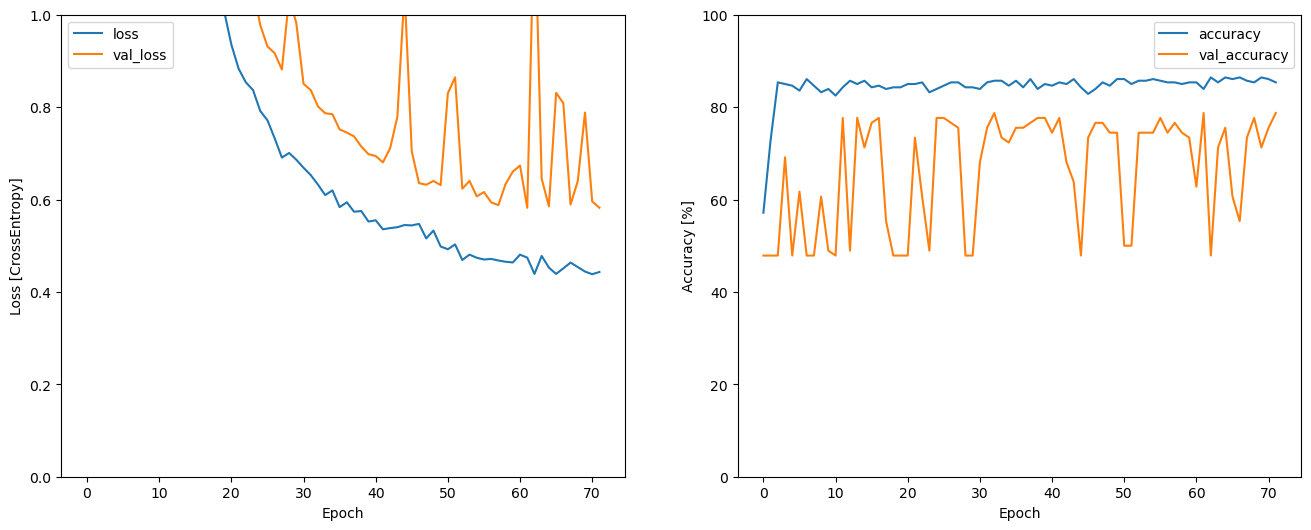

In [4]:
import matplotlib.pyplot as plt

metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
#plt.ylim([0, max(plt.ylim())])
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
